## Cluster convex hulls

In [17]:
def cluster_convex_hulls(gdf, template_da, burn_value=1, dilation_radius=10, res=20, original_crs="EPSG:4326", metric_crs="EPSG:32630"):
    hull_geoms = []
    reproj = pyproj.Transformer.from_crs(original_crs, metric_crs, always_xy=True).transform

    for cluster_id in gdf['Cluster'].unique():
        cluster_points = gdf.loc[gdf['Cluster'] == cluster_id, 'geometry']
        multipoint = MultiPoint(cluster_points.to_list())
        hull = multipoint.convex_hull
        hull = shapely_transform(reproj, hull)
        hull_geoms.append((hull, burn_value))

    # Get transform and shape from template raster
    lat_origin = template_da['lat'].values[0, 0]
    lon_origin = template_da['lon'].values[0, 0]
    x_origin, y_origin = reproj(lon_origin, lat_origin)
    transform = from_origin(x_origin, y_origin, res, res)
    out_shape = template_da.shape

    # Rasterize convex hulls
    mask_array = rasterize(
        hull_geoms,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    buffered_mask = binary_dilation(mask_array, structure=createKernel(dilation_radius))

    # Wrap in a DataArray
    mask_da = xr.DataArray(
        buffered_mask,
        coords=template_da.coords,
        dims=template_da.dims,
        name='cluster_convex_hull_mask'
    )

    return mask_da

In [16]:
tileId = '30UUA'

In [31]:
tile_habitats_gdf = habitats_gdf[(habitats_gdf['utm_tile'] == tileId) & (habitats_gdf['HabStatus'] == 'Present')]

In [32]:
tile_habitats_gdf

,GUI,RecordKey,HabType,HabSubType,HabStatus,Determiner,DetDate,SurveyKey,StartDate,EndDate,...,Longitude,AltHabType,AltHabClas,AltHabRel,SurveyDate,SurveyYear,utm_tile,Cluster,subtile_in,geometry
126932,OSPARHab2022GBDv1,MRLRC00300001263,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,19/05/2017,19/05/2017,...,-5.220109,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-19,2017,30UUA,558,16,POINT (-5.22011 49.94791)
126933,OSPARHab2022GBDv1,MRLRC0030000126A,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,18/05/2017,18/05/2017,...,-5.178603,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-18,2017,30UUA,558,16,POINT (-5.1786 49.96069)
126934,OSPARHab2022GBDv1,MRLRC0030000126B,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,18/05/2017,18/05/2017,...,-5.180711,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-18,2017,30UUA,558,16,POINT (-5.18071 49.96074)
126935,OSPARHab2022GBDv1,MRLRC0030000126D,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,19/05/2017,19/05/2017,...,-5.187564,A3.1151 - [Laminaria hyperborea] forest with d...,http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2017-05-19,2017,30UUA,558,16,POINT (-5.18756 49.96092)
126936,OSPARHab2022GBDv1,MRLRC00300000F7E,Kelp forests,Kelp forests dominated by Laminaria hyperborea,Present,JNCC,13/07/2022,None,29/06/2014,29/06/2014,...,-5.164993,"A3.2121 - [Laminaria hyperborea] forest, folio...",http://dd.eionet.europa.eu/vocabulary/biodiver...,included in,2014-06-29,2014,30UUA,558,17,POINT (-5.16499 50.00183)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144461,OSPARHab2022GBEv1,29737,Zostera beds,Zostera noltii beds,Present,JNCC,21/03/2023,NE_1805,None,21/03/2023,...,-4.980443,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2023-03-21,2023,30UUA,1396,25,POINT (-4.98044 50.22946)
144462,OSPARHab2022GBEv1,5214,Zostera beds,Zostera noltii beds,Present,JNCC,21/03/2023,NE_1805,None,21/03/2023,...,-4.980345,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2023-03-21,2023,30UUA,1396,25,POINT (-4.98034 50.22946)
144861,OSPARHab2022GBEv1,38085,Zostera beds,Zostera marina beds,Present,JNCC,21/03/2023,NE_1290,01/01/2012,31/12/2012,...,-4.635284,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2012-12-31,2012,30UUA,3639,37,POINT (-4.63528 50.32452)
144891,OSPARHab2022GBEv1,13086,Zostera beds,Zostera marina beds,Present,JNCC,21/03/2023,NE_0634,01/01/2013,31/12/2013,...,-4.636634,HOCI_17,https://www.marlin.ac.uk/habitats/hoci,included in,2013-12-31,2013,30UUA,3640,37,POINT (-4.63663 50.33012)


In [19]:
idepix_fp = os.path.join(DATA_DIR, f's2_processed/{tileId}/idepix-{tileId}.nc')
idepix_ds = xr.open_dataset(idepix_fp)

In [20]:
land_mask = (idepix_ds['pixel_classif_flags'].astype('int32') & 2**10) != 0

In [21]:
template_da = idepix_ds['pixel_classif_flags']

In [27]:
cluster_mask = cluster_convex_hulls(tile_habitats_gdf, template_da).astype(bool)

In [38]:
# Generate distinct colors
n_clusters = tile_habitats_gdf["Cluster"].nunique()
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))  # Sample tab20 colors
random.seed(101)
random.shuffle(colors)  # Shuffle colors for maximum contrast

# Create a color mapping
cluster_colors = {cluster_id: colors[i] for i, cluster_id in enumerate(sorted(tile_habitats_gdf["Cluster"].unique()))}

# Apply shuffled colors
tile_habitats_gdf["color"] = tile_habitats_gdf["Cluster"].map(cluster_colors)

/home/chanon/miniconda3/envs/geomlenv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: xlabel='longitude coordinate [degree]', ylabel='latitude coordinate [degree]'>

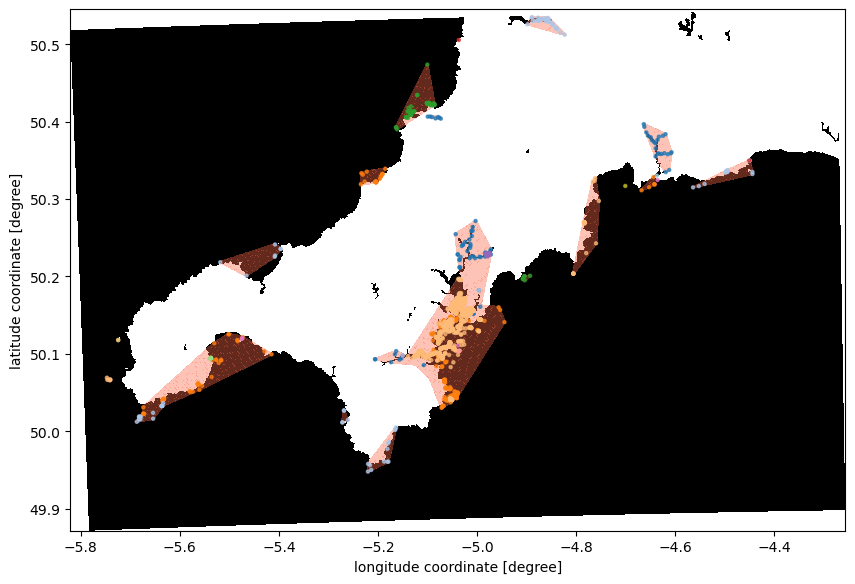

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
land_mask.plot(ax=ax, x='lon', y='lat', cmap='gray', add_colorbar=False)
cluster_mask.where(cluster_mask > 0).plot(
    ax=ax,
    x='lon',
    y='lat',
    cmap='Reds',
    alpha=0.4,
    add_colorbar=False
)

tile_habitats_gdf.plot(color=tile_habitats_gdf["color"], legend=False, ax=ax, markersize=5, alpha=0.7)

# plt.savefig(os.path.join(FIGURES_DIR, 'convex_hulls_example'))